In [0]:
from google.colab import files
import matplotlib.pyplot as plt
from scipy.linalg import circulant
import numpy as np
import time
from sklearn.decomposition import FastICA, PCA
from google.colab import drive

import imageio

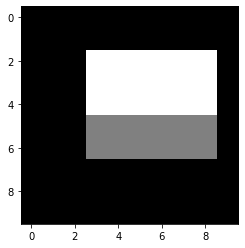

In [2]:
pic1 = np.zeros((10,10))
pic1[2:7,3:9] = 1

pic1[5:7, 3:9] = 0.5
plt.imshow(pic1,'gray')

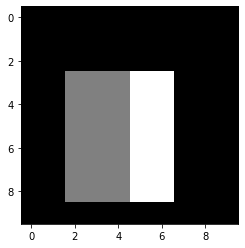

In [0]:

pic2 = np.zeros((10,10))
pic2[3:9,2:7] = 0.5

pic2[3:9, 5:7] = 1
plt.imshow(pic2,'gray')

In [2]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/35c067adcc1ab364c8803830cdb34d0d50eea37e/week01_backprop/mnist.py -O mnist.py

--2020-04-02 05:41:45--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/35c067adcc1ab364c8803830cdb34d0d50eea37e/week01_backprop/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [text/plain]
Saving to: ‘mnist.py’

mnist.py            100%[===================>]   2.63K  --.-KB/s    in 0s      

2020-04-02 05:41:45 (38.5 MB/s) - ‘mnist.py’ saved [2697/2697]



In [0]:
import mnist


In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

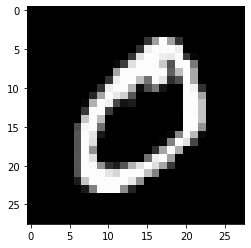

In [5]:
plt.imshow(X_train[1].reshape([28,28]),cmap='gray');

In [0]:
pic1 = X_train[0].reshape([28,28])
pic2 = X_train[1].reshape([28,28])

In [0]:
K = 10
L = 1500
N = 784

In [0]:

m1 = pic1.reshape((N,1))
m2 = pic2.reshape((N,1))

In [0]:

C = np.random.randn(L,N)


h1 = np.random.randn(K,1)
h2 = np.random.randn(K,1)
h3 = np.random.randn(K,1)
h4 = np.random.randn(K,1)

B = np.random.randn(L,K)
#B = np.eye(L,K)
#B2 = np.random.randn(L,K)

In [0]:
A = circulant(C[:,0]) @ B
for iter in range(1,N):
    elem = circulant(C[:,iter]) @ B
    A = np.hstack((A,elem))
#    print(iter)

In [0]:

X11 = h1 @ m1.reshape((1,N))
X12 = h2 @ m1.reshape((1,N))

X1 = np.vstack((X11,X12))

X21 = h3 @ m2.reshape((1,N))
X22 = h4 @ m2.reshape((1,N))

X2 = np.vstack((X21,X22))

In [0]:
X = X1 + X2

In [0]:
a, b = A.shape
A0 = np.zeros((a,b))
A1 = np.hstack((A,A0))
A2 = np.hstack((A0,A))
A = np.vstack((A1,A2))

In [0]:

y =  A @ X.reshape((2*N*K,1))

In [0]:

def prox_nuclear(A, lambd):
    U, S, Vh = np.linalg.svd(A)
    svp = np.sum(S > lambd)
    if svp >= 1:
        S = S[:svp] - lambd
        X = U[:,:svp] @ np.diag(S) @ Vh[:svp]
        nucnorm = np.sum(S)
    else:
        X = np.zeros(A.shape)
        nucnorm = 0
    return X, nucnorm

In [0]:
def prox_l21(A,lambd):
    X = np.zeros(A.shape)
    for i in range(X.shape[1]):
        nxi = np.linalg.norm(A[:,i])
        if nxi > lambd:
            X[:,i] = (1 - lambd/nxi) * A[:,i]
    return X
    

In [0]:


def lrr(y, A, lambd):
    tol = 1e-4
    max_iter = 500
    ro = 1.1
    mu = 1e-4
    max_mu = 1e10

    d, na = y.shape
    a, nb = A.shape
    #X = np.zeros((nb, na))
    X = np.zeros((2*K,N))
    E = np.zeros((d, na))
    J = X

    Y1 = E
    Y2 = X
   
    Ablock = A[:int(a/2),:int(nb/2)]

    AtA = Ablock.T @ Ablock
    Aty = A.T @ y
    I = np.eye(int(nb/2))
    invAtAIblock = np.linalg.inv(AtA + I)
    zeros = np.zeros((int(nb/2),int(nb/2)))
   # print(invAtAIblock.shape, zeros.shape)
    invAtAI = np.vstack((np.hstack((invAtAIblock,zeros)), np.hstack((zeros,invAtAIblock))))
  
    errs = []
    times = []
    start = time.time()

    for iter in range(max_iter):
      

        J, nuclearnormJ = prox_nuclear(X+Y2/mu, 1/mu)
        E = prox_l21(y - A @ X.reshape((2*K*N,1)) + Y1/mu, lambd/mu)

        X = (invAtAI @ ((A.T @ (Y1/mu -E) + Aty).reshape((2*K,N)) - Y2/mu + J).reshape((2*K*N,1))).reshape((2*K,N))
        dY1 = y - A @ X.reshape((2*K*N,1)) - E
        dY2 = X - J

        Y1 += mu * dY1
        Y2 += mu * dY2
        mu = min(ro*mu, max_mu)
        times.append(time.time() - start)
       
        metric = np.linalg.norm(y - A @ X.reshape((2*K*N,1)))
        print(metric)
        errs.append(metric)
        if metric < tol:
            break
    return J, E, errs, iter, times

In [17]:
Xk, E, errs, iters, times = lrr(y, A, 100)

0.007109328853004959
0.007093461083845282
0.007103100027629995
0.007085410026242969
0.007112415091280543
0.007107095336339419
0.007102095592930577
0.007101477881196574
0.007097714635380894
0.00711011838044681
0.007102096814319472
0.007100494986816488
0.007098903434588978
0.007105596949308006
0.0071048962458562515
0.007093252517183231
0.007100652745854289
0.007098012564442134
0.007111122407787789
0.007092799042454901
0.007103574668880799
0.007094808846428132
0.007114200716674498
0.0071043742898377876
0.00711058263836947
0.007093829989309407
0.007098703424026127
0.007107035232449858
0.007098144411274733
0.007108512898792554
0.007100345910726824
0.007106377762239603
0.007105674097693624
0.007100741980281103
0.007098269525906407
0.007097936006179171
0.00710289056639795
0.007095280775582778
0.00710471338428332
0.007098803886012188
0.007101923473683773
0.007098792085317565
0.007115069500219791
0.007101153340163464
0.007096622422253259
0.007101894484473837
0.007089600380988405
0.0071151717088

In [0]:


u, s, v = np.linalg.svd(Xk1)

In [30]:

s

array([41.98621815, 37.60133861, 22.89184971, 20.53844827, 12.81711722,
       11.12082822, 10.54830903,  8.72029875,  7.47025489,  6.31296644,
        5.55337158,  5.26816321,  4.97680037,  3.64234043,  2.78025616,
        2.40049564,  2.03546058,  1.90573746,  1.14114186,  0.98457565])

In [0]:
mi = np.max(v[0,:])

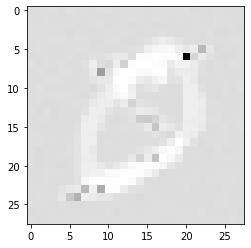

In [35]:
im1 = (-v[0,:]).reshape((28,28))
plt.imshow(im1,'gray')

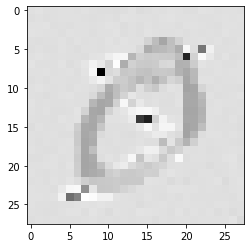

In [33]:
im2 = (-v[1,:]).reshape((28,28))
plt.imshow(im2,'gray')

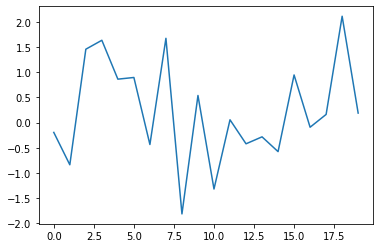

In [54]:
plt.plot(np.vstack((h3,h4)))

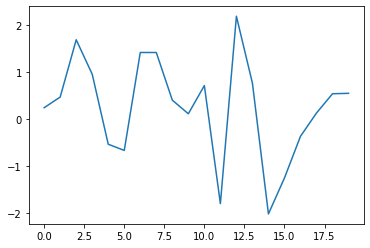

In [58]:
plt.plot(np.vstack((h1,h2)))

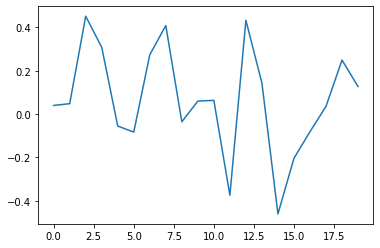

In [57]:

plt.plot(-u[:,0]-0.5*u[:,1])

In [59]:
times

[0.12782621383666992,
 0.276932954788208,
 0.4265773296356201,
 0.5752325057983398,
 0.7291343212127686,
 0.8801007270812988,
 1.0306179523468018,
 1.1796741485595703,
 1.331618070602417,
 1.4806787967681885,
 1.6314032077789307,
 1.7826859951019287,
 1.9374704360961914,
 2.0882761478424072,
 2.2403011322021484,
 2.395017147064209,
 2.559659004211426,
 2.708204984664917,
 2.867178201675415,
 3.0213403701782227,
 3.170931100845337,
 3.319551706314087,
 3.4697701930999756,
 3.6184487342834473,
 3.770854949951172,
 3.9279837608337402,
 4.0805628299713135,
 4.229298830032349,
 4.38348650932312,
 4.534837484359741,
 4.68865704536438,
 4.8418052196502686,
 4.994008541107178,
 5.143083810806274,
 5.292176246643066,
 5.4406578540802,
 5.593298435211182,
 5.742007493972778,
 5.897908687591553,
 6.056574583053589,
 6.209810256958008,
 6.358985185623169,
 6.510350227355957,
 6.660319566726685,
 6.81524920463562,
 6.968506336212158,
 7.130388021469116,
 7.280163049697876,
 7.4324116706848145,
 7.5

In [0]:
def So(tau,X):
    r = np.multiply(np.sign(X) , np.max(np.abs(X) - tau, 0))

    return r

def Do(tau, X):
    U, S, Vh = np.linalg.svd(X)
    add = Vh.shape[1] - len(S)
  
    S_trunc = So(tau, np.diag(S))
    if add > 0:
        zeros = np.zeros((len(S), add))
        S_trunc = np.hstack((S_trunc, zeros))
    r = U @ S_trunc @ Vh
    return r



In [0]:
#https://github.com/dlaptev/RobustPCA/blob/master/RobustPCA.m

def robustPCA(X):

    M, N = X.shape
    normX = np.linalg.norm(X, 'fro')

    lambd = 0.1
    
    #1 / np.sqrt(max(M,N))
  
    mu = 85 * lambd
    tol = 0.0003
    max_iter = 1000

    L = np.zeros((M,N))
    S = np.zeros((M,N))
    Y = np.zeros((M,N))

    for iter in range(max_iter):
        L = Do(1/mu, X - S + (1/mu)*Y)
        S = So(lambd/mu, X - L + (1/mu)*Y)
        Z = X - L - S
        Y = Y + mu*Z
        err = np.linalg.norm(Z, 'fro') / normX
        if err < tol:
            break
        print(err)
    return L, S

In [28]:


Xk1, Xk2 = robustPCA(Xk)

0.01867740236891487
0.025022808750223
0.04251385328686047
0.03745235519485222
0.03447842061265658
0.03961028226753843
0.037517096138261194
0.03645154699798413
0.038103264106916286
0.03832699142103393
0.0368630277944677
0.03731346603000945
0.03839585616352855
0.03772913536342712
0.03749679242414469
0.038594128829848265
0.03828251101477132
0.037523474233158924
0.03825917993268238
0.03841449181085047
0.03779495015173205
0.037981414595135383
0.038721809187609126
0.03845376262118561
0.03821513675076373
0.03895085439792646
0.038726407759362085
0.03805081530604502
0.0385042218320391
0.03896591934693014
0.038408497261881024
0.03841250131993124
0.0386287367504797
0.038289090751554636
0.03856803167610069
0.03904662299746165
0.038551854641439384
0.03821123062692408
0.039038990536105274
0.038642605218466325
0.0383154474656847
0.039589726243132894
0.03913886322903032
0.03756275642984023
0.03892192895809874
0.04008481870528229
0.037968390995368424
0.037818702970868326
0.04073779488968171
0.039294410

In [0]:
S_ = ica.fit_transform(obs) 

In [0]:
S_

array([[-1.35549970e-03, -6.10173872e-02],
       [ 1.13731825e-03, -6.00675939e-02],
       [-1.85634558e-03, -6.14627906e-02],
       [-8.67932955e-04, -6.03321759e-02],
       [ 9.55771809e-05, -6.08076774e-02],
       [-6.57791405e-04, -6.02814059e-02],
       [-4.52816731e-04, -6.03065964e-02],
       [ 1.48741677e-03, -5.96495114e-02],
       [ 1.10956842e-03, -6.06136347e-02],
       [-3.65289722e-04, -6.02586264e-02],
       [-4.48874574e-04, -6.00450848e-02],
       [ 8.12655348e-04, -6.01680691e-02],
       [ 6.81035556e-04, -6.04960714e-02],
       [-1.43314352e-04, -6.10374891e-02],
       [-1.88992175e-03, -6.11431603e-02],
       [-1.20236541e-03, -6.02392478e-02],
       [-1.87670747e-03, -6.08524638e-02],
       [-1.00854836e-03, -6.01370944e-02],
       [ 1.61670655e-03, -6.05970732e-02],
       [-1.26594428e-03, -6.05269082e-02],
       [ 1.87386525e-04, -5.99555390e-02],
       [ 2.05651875e-03, -5.93365285e-02],
       [-8.38351032e-04, -6.01741308e-02],
       [-2.

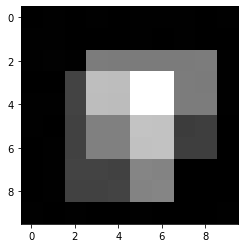

In [0]:
plt.imshow(S_[:,1].reshape(10,10), 'gray')